In [2]:
!pip install pyyaml
!pip install matplotlib-venn

In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set_style("whitegrid")
from pprint import pprint
import sqlite3
import yaml
import re
import datetime

try: # for pip >= 10
    from pip._internal.req import parse_requirements
except ImportError: # for pip <= 9.0.3
    from pip.req import parse_requirements

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")

## Easier navigation:

------------------------------------

### 1. <a href='#setup'>Setup</a>
------------------------------------
### 2. <a href='#cdist'>Column distributions</a>
### 3. <a href='#ok'>`column`: ok</a>
### 4. <a href='#seda'>Spec EDA</a>
### 5. <a href='#sinp'>Sample Inputs for each column</a>
------------------------------------
### 6. <a href='#conda'>`column`: conda - parse</a>
### 7. <a href='#pip'>`column`: pip - parse</a>
### 8. <a href='#dpdf'>Building a dependency df on conda/pip</a>
------------------------------------

<a name='setup'></a>
## 1. Setup

<br>

In [2]:
con = sqlite3.connect('binder-launches.db')
df = pd.read_sql('SELECT * FROM binder', con)

In [3]:
df.columns

Index(['timestamp', 'version', 'provider', 'spec', 'ref', 'origin', 'repo',
       'resolved_ref', 'org'],
      dtype='object')

In [4]:
df

,timestamp,version,provider,spec,ref,origin,repo,resolved_ref,org
0,2021-01-21T00:00:00+00:00,4,GitHub,ipython/ipython-in-depth/master,master,turing.mybinder.org,ipython/ipython-in-depth,7e5ce96cc9251083979efdfc393425f1229a4a68,ipython
1,2021-01-21T00:00:00+00:00,4,GitHub,ipython/ipython-in-depth/master,master,turing.mybinder.org,ipython/ipython-in-depth,7e5ce96cc9251083979efdfc393425f1229a4a68,ipython
2,2021-01-21T00:00:00+00:00,4,GitHub,jupyterlab/jupyterlab-demo/master,master,turing.mybinder.org,jupyterlab/jupyterlab-demo,79184a07d47cf03787b39cfc345da98794d76554,jupyterlab
3,2021-01-21T00:00:00+00:00,4,GitHub,qiskit-community/qiskit-textbook/thebe-stable,thebe-stable,turing.mybinder.org,qiskit-community/qiskit-textbook,5427cf2721cc352a522832a67845d6b59e04666b,qiskit-community
4,2021-01-21T00:00:00+00:00,4,GitHub,furnstahl/5300-notebooks/master,master,gke.mybinder.org,furnstahl/5300-notebooks,aa03b995e36957a72fee85be8d2a52aea451422a,furnstahl
...,...,...,...,...,...,...,...,...,...
13946913,2018-11-03T23:58:00+00:00,1,GitHub,ipython/ipython-in-depth/master,master,None,ipython/ipython-in-depth,,ipython
13946914,2018-11-03T23:58:00+00:00,1,GitHub,ipython/ipython-in-depth/master,master,None,ipython/ipython-in-depth,,ipython
13946915,2018-11-03T23:58:00+00:00,1,GitHub,ines/spacy-io-binder/live,live,None,ines/spacy-io-binder,,ines
13946916,2018-11-03T23:58:00+00:00,1,GitHub,ipython/ipython-in-depth/master,master,None,ipython/ipython-in-depth,,ipython


In [5]:
dash = '-' * 60

<a name='cdist'></a>
## 2. Column distributions

<br>

<AxesSubplot:xlabel='version', ylabel='count'>

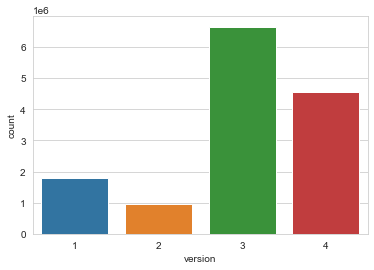

In [6]:
sns.countplot(x="version", data=df)

<AxesSubplot:xlabel='provider', ylabel='count'>

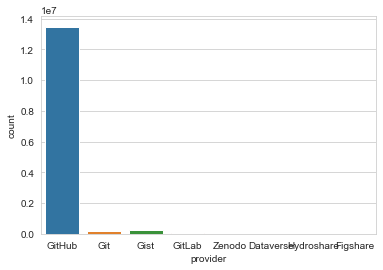

In [7]:
sns.countplot(x="provider", data=df)

In [8]:
len(df["repo"].unique())

112753

Since the "repo" and "ref" columns are the ones to merge with the specs dataset, it would be useful to see how many unique branches there are.

In [9]:
unique_b = len(pd.unique(df[['repo', 'ref']].values.ravel('K')))
unique_b

171770

This means that on average, each branch has about ~ entries:

In [10]:
len(df) / unique_b

81.19530767887291

In [11]:
con = sqlite3.connect('binder-specs.sqlite')
temdf = pd.read_sql('SELECT * FROM specs', con)

In [12]:
merged_df = pd.merge(df, temdf,  how='left', left_on=['repo','ref'], right_on = ['remote','git_ref'])

In [14]:
merged_df["repo"]

0             ipython/ipython-in-depth
1             ipython/ipython-in-depth
2             ipython/ipython-in-depth
3             ipython/ipython-in-depth
4           jupyterlab/jupyterlab-demo
                       ...            
62466012          ines/spacy-io-binder
62466013      ipython/ipython-in-depth
62466014      ipython/ipython-in-depth
62466015      ipython/ipython-in-depth
62466016      ipython/ipython-in-depth
Name: repo, Length: 62466017, dtype: object